In [1]:
import tensorflow as tf
from psychrnn.backend.models.basic import Basic
from psychrnn.backend.gain.gain3 import Gain3
from psychrnn.backend.gain.loss import rt_mask_mse_06, rt_mask_mse_07, rt_mask_mse_08
from psychrnn.tasks.checker2 import Checkerboard2AFC

from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import os

In [2]:
experiment = 'interactive'
name = 'basic'
dt = 10
tau = 50
T = 5000
N_batch = 50
N_rec = 100

g0_bound = [0, 1]
gSlope_bound = [0,0.05]

# Generate a batch of trials with linear gain

In [3]:
task = Checkerboard2AFC(dt=dt, tau=tau, T=T, N_batch=N_batch, g0_bound = g0_bound, gSlope_bound = gSlope_bound)

In [4]:
params = task.get_task_params()
params

{'N_batch': 50,
 'N_in': 4,
 'N_out': 2,
 'dt': 10,
 'tau': 50,
 'T': 5000,
 'alpha': 0.2,
 'N_steps': 500,
 'coherence': [-0.9, 0.9],
 'side': 0.5,
 'noise': 0.25,
 'target_onset': [250, 500],
 'checker_onset': [500, 1000],
 'accumulation_mask': 300,
 'decision_threshold': 0.7,
 'post_decision_baseline': 0.2,
 'wait': 0.2,
 'hi': 1,
 'lo': 0,
 'g0_bound': [0, 1],
 'gSlope_bound': [0, 0.05]}

In [5]:
[x, y, mask, allParams, g, gainParams] = task.get_trial_batch()

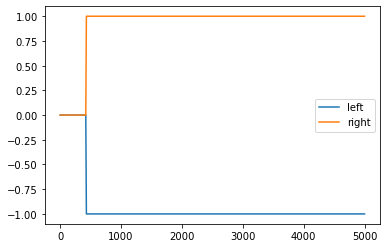

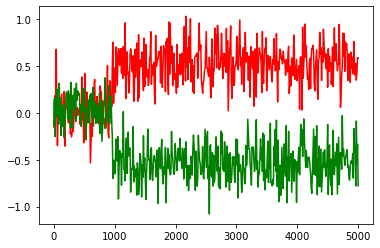

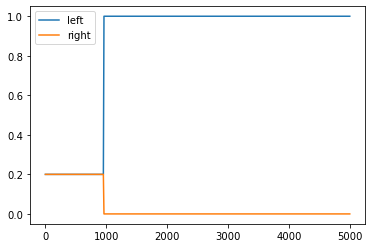

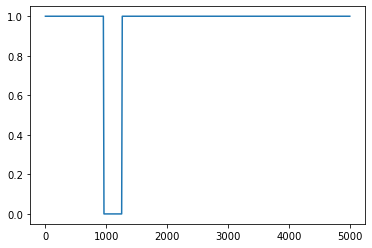

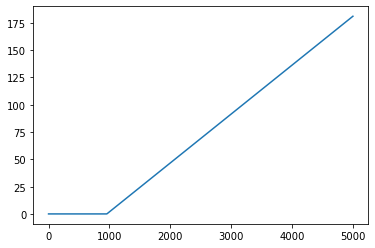

[0.14787844 0.04482563]


In [6]:
# 1a: left tartet red (-1) or green (+1)
# 1b: right target red (-1) or green (+1)
# 2a: red coherence (-1 to 1) ()
# 2b: green coherence (-1 to 1) (G-R) / (R+G)
trialIn = x[1,:,:]
trialOut = y[1,:,:]
trialMask = mask[1,:,:]
time = np.linspace(0, task.T, int(task.T/task.dt))
# plot input to the model
plt.figure()
plt.plot(time, trialIn[:,0], label = 'left')
plt.plot(time, trialIn[:,1], label = 'right')
plt.legend()

plt.figure()
plt.plot(time, trialIn[:,2], color = 'red')
plt.plot(time, trialIn[:,3], color = 'green')
# plot output to the model
plt.figure()
plt.plot(time, trialOut[:,0], label = 'left')
plt.plot(time, trialOut[:,1], label = 'right')
plt.legend()
# plot trial masks
plt.figure()
plt.plot(time, trialMask[:,0])
# plot gain
plt.figure()
plt.plot(time, g[1,:,:])
plt.show()
print(gainParams[1,:])

# Set Network params

In [7]:
network_params = task.get_task_params()
network_params['name'] = name
network_params['N_rec'] = N_rec
network_params['rec_noise'] = 0.5

network_params["transfer_function"] = tf.nn.relu
network_params["output_transfer_function"] = tf.nn.sigmoid

network_params["loss_function"] = "rt_mask_mse"
network_params["rt_mask_mse"] = rt_mask_mse_07


In [9]:
try:
    model.destruct()
except:
    pass

model = Gain3(network_params)

# Set Training params & Train

In [10]:
trials = 25000
train_params = {}
train_params['save_weights_path'] =  "./weights/Gain31stTry"
train_params['training_iters'] = trials
train_params['learning_rate'] = .001
train_params['loss_epoch'] = 10
train_params['save_training_weights_epoch'] = 1000 / N_batch
train_params['training_weights_path'] = None

In [11]:
losses, initialTime, trainTime = model.train(task, train_params)
loss_name = "./losses/Gain31stTry.txt"
print("Save losses to " + loss_name)
with open(loss_name, 'w') as f:
    for item in losses:
        f.write("%s\n" % item)

AttributeError: 'Gain3' object has no attribute 'g'